## Import data

In [19]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from analysis_lib.one_sample_tests import KolmogorovSmirnov
from factorial_anova_analysis import get_raw_data

index = "rtxfactorial1" # cars: 750, smart cars: 750, no pendulum (= rtx50)
index = "rtxgaussian-baseline" # cars: 750, smart cars: 750, no pendulum (= rtx50), gaussian with 

knob_name = "re_route_every_ticks"
knob_values = [10, 70] 

results = get_raw_data(index, False)

res = {}
data = {}
knobs = {}

print knob_name 
print "---------"
for i in knob_values:    
    res = [r for r in results if r[1].get(knob_name)==i]
    data[i] = [r[0] for r in res]
    knobs[i] = [r[1] for r in res]
    print str(i)+"'s: " + str(len(data[i]))
print "========="

data retrieved from file rtxfactorial1.pickle
re_route_every_ticks
---------
10's: 640000
70's: 640000


## Boxplots

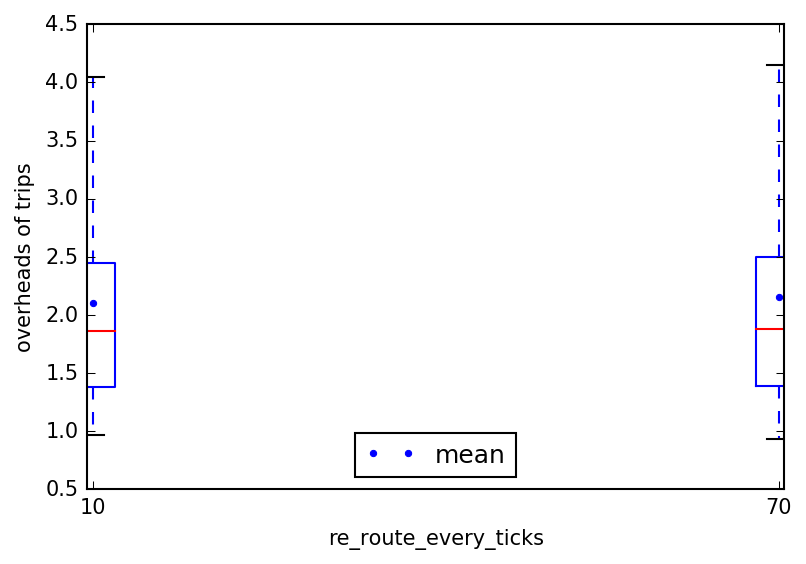

In [21]:
import matplotlib.pyplot as plt
from numpy import var, std, mean, median
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
import random

def getWidth(keys):
    highest_key = max(keys)
    if highest_key < 1:
        return 0.1
    if 1 <= highest_key < 10:
        return 0.2
    if 10 <= highest_key < 50:
        return 1
    if 50 <= highest_key < 100:
        return 4
    if 100 <= highest_key < 1000:
        return 30
    
y_key = 'overhead'
sample_size = 30000

means = []
all_data = []

for i in knob_values:
    raw_data = [r[y_key] for r in data[i]]
#     analysis_data = random.sample(raw_data, sample_size)
    analysis_data = raw_data[:sample_size]
    all_data.append(analysis_data)
    means.append(mean(analysis_data))
        
fig,ax = plt.subplots()
ax.plot(knob_values,means, ".", label='mean')
ax.boxplot(all_data, 0, '', positions=knob_values, widths=[getWidth(knob_values) for k in knob_values])
plt.xticks(knob_values, [str(k) for k in knob_values])
plt.legend(loc='best')
plt.ylabel('overheads of trips')
plt.xlabel(knob_name)
plt.show()

## Ttests with variable sample sizes

Complaints for configuration re_route_every_ticks=70: 19, ratio: 0.19
0.98176138939
Complaints for configuration re_route_every_ticks=70: 48, ratio: 0.24
0.676459783075
Complaints for configuration re_route_every_ticks=70: 72, ratio: 0.24
0.695842258387
Complaints for configuration re_route_every_ticks=70: 93, ratio: 0.2325
0.83668543818
Complaints for configuration re_route_every_ticks=70: 122, ratio: 0.244
0.661935022874
Complaints for configuration re_route_every_ticks=70: 142, ratio: 0.236666666667
0.820004753893
Complaints for configuration re_route_every_ticks=70: 167, ratio: 0.238571428571
0.803869387429
Complaints for configuration re_route_every_ticks=70: 187, ratio: 0.23375
0.884168273996
Complaints for configuration re_route_every_ticks=70: 209, ratio: 0.232222222222
0.912506426145
Complaints for configuration re_route_every_ticks=70: 244, ratio: 0.244
0.69776213624
Complaints for configuration re_route_every_ticks=70: 275, ratio: 0.25
0.511080309858
Complaints for configura

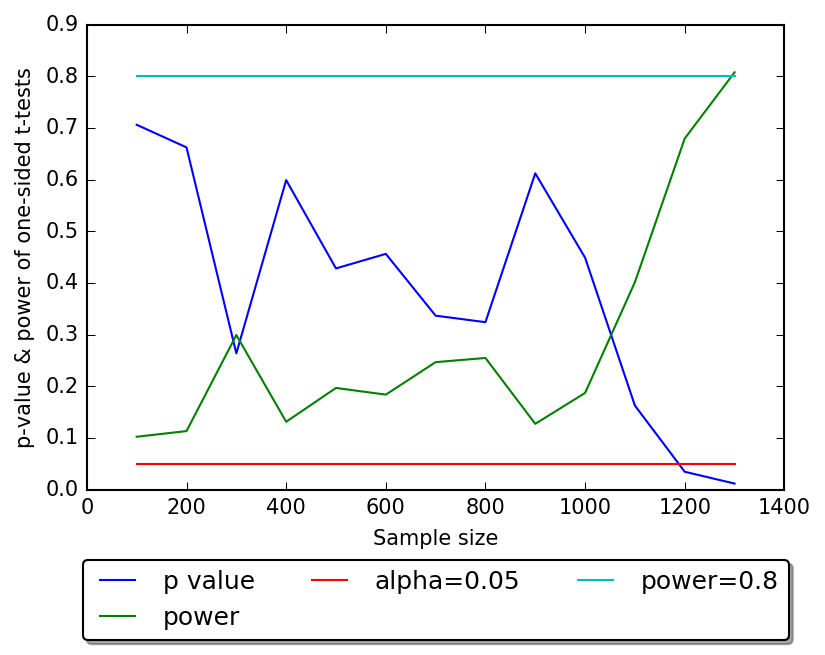

In [24]:
from analysis_lib.two_sample_tests import Ttest
from analysis_lib.two_sample_tests import TtestPower
from complaints_generator import generate_complaints
from scipy.stats import binom_test
mpl.rc("savefig", dpi=150)

alpha = 0.05
necessary_power = 0.80
min_mean_diff = 0.1

complaints_threhold = 2.5

fake_run_id = "123456"

def generate_complaints(overheads, complaint_threshold):
    complaints = []
    for overhead in overheads:
        if overhead > complaint_threshold:
            complaints.append(1)
        else:
            complaints.append(0)
    return complaints

this_knob_value = knob_values[0]    # or (reverse order): this_knob_value = knob_values[1]
other_knob_values = knob_values[1:] # or (reverse order): other_knob_values = [knob_values[0]]

sample_sizes = []
pvalues = {}
powers = {}

for i in knob_values:
    pvalues[i] = []
    powers[i] = []

stop = False
interrupted = False
complaints_count = 0
complaints_absolute_threshold = 200
complaints_ratio_threshold = 0.25
step = 100

for sample_size in range(100, 10000, step):
#     print "--------"
#     print "Sample size: " + str(sample_size)
    sample_sizes.append(sample_size)
    
    analysis_data = {}
    raw_data = data[this_knob_value] 
    analysis_data[0] = raw_data[:sample_size] #  also: 
#     analysis_data[0] = random.sample(raw_data, sample_size)
    
    complaints_0 = generate_complaints([d[y_key] for d in analysis_data[0]], complaints_threhold)
#     complaints_count += sum(complaints_0)
    complaints_0_ratio = sum(complaints_0)/float(len(complaints_0))
#     print "Complaints for configuration " + knob_name + "=" + str(this_knob_value) + ": " \
#         + str(sum(complaints_0)) + ", ratio: " + str(complaints_0_ratio)   
    
    next_complaints_0_no = len(complaints_0) + step
    predicted_complaints_0_no = int(next_complaints_0_no * complaints_0_ratio)
#     print "At the next step, complaints are expected to be: " + str(predicted_complaints_0_no)
    p_val = binom_test(predicted_complaints_0_no, next_complaints_0_no, complaints_ratio_threshold, alternative="greater")
#     print p_val
    
    for other_knob_value in other_knob_values:   
        raw_data = data[other_knob_value] 
        analysis_data[1] = raw_data[:sample_size] #  also: 
#         analysis_data[1] = random.sample(raw_data, sample_size)
    
        complaints_1 = generate_complaints([d[y_key] for d in analysis_data[1]], complaints_threhold)
#         complaints_count += sum(complaints_0)
        complaints_1_ratio = sum(complaints_1)/float(len(complaints_1))
        print "Complaints for configuration " + knob_name + "=" + str(other_knob_value) + ": " \
            + str(sum(complaints_1)) + ", ratio: " + str(complaints_1_ratio)   

        next_complaints_1_no = len(complaints_1) + step
        predicted_complaints_1_no = int(next_complaints_1_no * complaints_1_ratio)
#         print "At the next step, complaints are expected to be: " + str(predicted_complaints_1_no)
        p_val = binom_test(predicted_complaints_1_no, next_complaints_1_no, complaints_ratio_threshold, alternative="greater")
        print p_val
        if p_val < alpha: 
            print "================"
            print "Sample size: " + str(sample_size)
            print "If we continue, we will have a complaint rate higher than " + str(complaints_ratio_threshold) + \
                " (pvalue: " + str(p_val) + ")"
            print "So we abort here."
            print "================"
            interrupted = True
            break
        
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        pvalues[other_knob_value].append(t["pvalue"])
        one_sided_p_value = t["pvalue"]/2
        
        if t["statistic"] < 0:
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'smaller').start(analysis_data, {})            
        else: 
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'larger').start(analysis_data, {})            
        powers[other_knob_value].append(t_p["power"])
        
#         if one_sided_p_value < alpha and t_p["power"] >= necessary_power and abs(t["mean_diff"]) > min_mean_diff:
        if one_sided_p_value < alpha and t_p["power"] >= necessary_power:
            different = "smaller" if t["statistic"] < 0 else "larger"
            print "================"
            print "Overhead in " + str(this_knob_value) + " is " + different + " than in " + str(other_knob_value)
            print "sample size: " + str(sample_size)                                 
            print "mean difference: " + str(t["mean_diff"]) 
            print "p value: " + str(one_sided_p_value)                                 
            print "effect size: " + str(t["effect_size"]) 
            print "power: " + str(t_p["power"])
            print "================"
            stop = True
            break
    if stop or interrupted: break

if not interrupted:
    fig,ax = plt.subplots()
    for i in other_knob_values:
        ax.plot(sample_sizes,pvalues[i],label='p value')
        ax.plot(sample_sizes,powers[i],label='power')

    ax.plot(sample_sizes,[alpha]*len(sample_sizes), label='alpha='+str(alpha))
    ax.plot(sample_sizes,[necessary_power]*len(sample_sizes), label='power='+str(necessary_power))
    # ax.set_frame_on(False)
    plt.xlabel('Sample size')
    plt.ylabel('p-value & power of one-sided t-tests')

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=3, fancybox=True, shadow=True)
#     plt.legend(loc='lower center')
    plt.show()

## Sample size estimation for t test

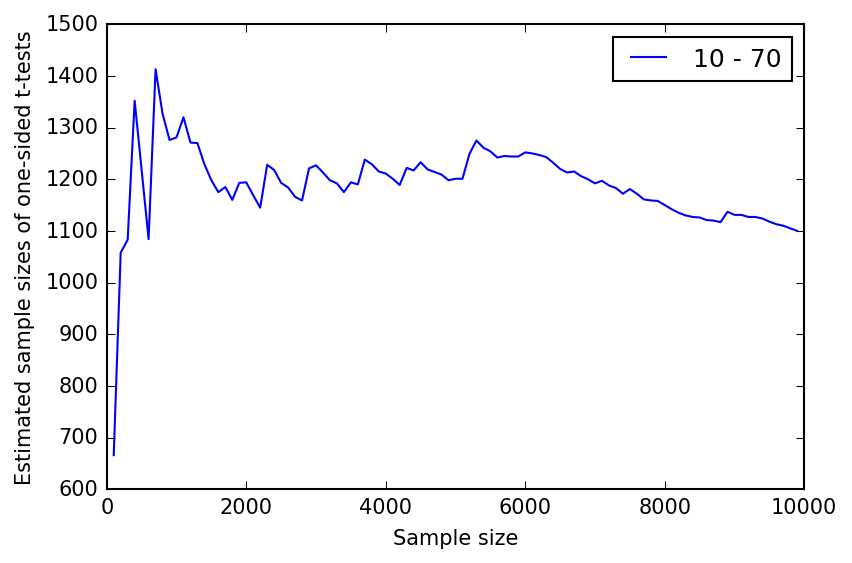

In [31]:
# %load_ext autoreload
# %autoreload 2
from analysis_lib.two_sample_tests import TtestSampleSizeEstimation
mpl.rc("savefig", dpi=150)

alpha = 0.05
necessary_power = 0.80
effect_size = -0.0986714843151
mean_diff = -0.135181531907

fake_id = "123456"
this_knob_value = knob_values[0]
other_knob_values = knob_values[1:]

sample_sizes = []
calc_sample_sizes = {}

for knobv in knob_values:
    calc_sample_sizes[knobv] = []

cnt_smaller = 0
cnt_greater = 0

for sample_size in range(100, 10000, 100):
    sample_sizes.append(sample_size)
    
    analysis_data = {}
    raw_data = data[this_knob_value]
    analysis_data[0] = raw_data[:sample_size]
    
    for other_knobv in other_knob_values:   
        raw_data = data[other_knobv]
        analysis_data[1] = raw_data[:sample_size]
        if mean_diff < 0:
            t_s = TtestSampleSizeEstimation(fake_id, y_key, None, mean_diff, alpha, necessary_power, 'smaller').start(analysis_data, {})
        else:
            t_s = TtestSampleSizeEstimation(fake_id, y_key, None, mean_diff, alpha, necessary_power, 'larger').start(analysis_data, {})
        calc_sample_sizes[other_knobv].append(t_s["sample_size"])

fig,ax = plt.subplots()
for other_knobv in other_knob_values:
    ax.plot(sample_sizes,calc_sample_sizes[other_knob_value],label=str(this_knob_value) + ' - ' + str(other_knobv))
    
plt.xlabel('Sample size')
plt.ylabel('Estimated sample sizes of one-sided t-tests')
plt.legend()
plt.show()